In [4]:
import numpy as np
import scipy 
import skbio
import pandas as pd
import os
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Calculate alpha diversity 


## Calculate alpha diversity using species abundance produced by metaphlan2

In [6]:
#load metaphlan2 species abundance

df_species=pd.read_csv('./data/metaphlan2_species_level_abundance_classified.csv',index_col=0)
df_species=df_species.fillna(value=0)
df_species=df_species.drop('PLCL19621_1',1)

#load the species abundance profile with species name abundance replaced by taxonID
# This is to ensure the consistency between phylo tree and abundance profile
df_spe_taxID=pd.read_csv('./data/metaphlan2_species_abundance_taxonID.csv',index_col=0)
df_spe_taxID=df_spe_taxID.fillna(value=0)
df_spe_taxID=df_spe_taxID.drop('PLCL19621_1',1)

In [7]:
##load metadata 
df_meta=pd.read_csv('./data/metadata_updated_filtered_201909.csv',index_col=0)
df_meta
df_meta=df_meta.fillna(value=100)

#create dictionary that stores patients information
dic_subtype=dict(zip(df_meta.index,df_meta.disease))
dic_disease_more=dict(zip(df_meta.index,df_meta.disease_subtype))
dic_complication=dict(zip(df_meta.index, df_meta.crohns_disease_behavior))
dic_sample_host=dict(zip(list(df_meta.index),list(df_meta.host_id)))
dic_surgery=dict(zip(list(df_meta.index),list(df_meta.surgery_type)))
dic_activity=dict(zip(list(df_meta.index),list(df_meta.endoscopic_activity)))

#additional dictionary to stratify patients
dic_cat1=dict(zip(df_meta.index,df_meta.category1))
dic_cat2=dict(zip(df_meta.index,df_meta.category2))
dic_cat3=dict(zip(df_meta.index,df_meta.category3))

In [8]:
## split the patients into UC, CD and with/without surgery group 
colectomy=[]
ilealcolonic=[]
sugery_none=[]

for i in df_species.columns: 
    if i in dic_subtype.keys(): 
        if dic_surgery[i]=='colectomy' or dic_surgery[i]=='colectomy with ileorectal' or dic_surgery[i]=='colectomy with ileostomy': 
            colectomy.append(i)
        elif dic_surgery[i]=='none': 
            sugery_none.append(i)
        else: 
            ilealcolonic.append(i)
            
print ('Number of samples in colectomy group: ', len(colectomy))
print ('Number of samples in ilealcolonic group: ',len(ilealcolonic))
print ('Number of samples in no surgery group: ',len(sugery_none))


Number of samples in colectomy group:  44
Number of samples in ilealcolonic group:  46
Number of samples in no surgery group:  210


## alpha diversity for non-phylogenetic metrics

In [9]:
from skbio.diversity import alpha_diversity

#preprocess data - alpha diversity function only takes in integers
df=df_species.transpose()
data_pre=100000*pd.DataFrame.as_matrix(df_species.transpose())
data=data_pre.astype(int)
ids=df.index

#observed OTU
adiv_otus = alpha_diversity('observed_otus', data, ids)
print ('Mean alpha diversity of all samples (observed OTU): ' )
print (str(np.mean(list(adiv_otus.data))))

#shannon
adiv_shannon = alpha_diversity('shannon', data, ids)
print ('Mean alpha diversity of all samples (shannon): ' )
print (str(np.mean(list(adiv_shannon.data))))


Mean alpha diversity of all samples (observed OTU): 
54.46
Mean alpha diversity of all samples (shannon): 
3.2108061723247414


## Alpha diversity with phylogenetic metric: Faith

In [10]:
from skbio import TreeNode
from io import StringIO

# load phylogenetic tree built in the preprocessing notebook
with open('./data/phylotree_sandborn.nw', 'r') as myfile:
    data=myfile.read()
tree=TreeNode.read(StringIO(data))
otuid=[str(i) for i in df.columns]


#preprocess data - alpha diversity function only takes in integers
df=df_spe_taxID.transpose()
data_pre=100000*pd.DataFrame.as_matrix(df_spe_taxID.transpose())
data=data_pre.astype(int)
ids=df.index
otuid=[str(i) for i in df.columns]

adiv_faith = alpha_diversity('faith_pd', data,ids=list(ids),otu_ids=otuid, tree=tree)
print ('Mean alpha diversity of all samples (Faith): ' )
print (str(np.mean(list(adiv_faith.data))))

## save alpha diversity into a csv file 
#adiv_faith.to_csv('../data/Sandborn_data/metadata/Alpha_diversity_faith.csv')

Mean alpha diversity of all samples (Faith): 
107.30666666666667


In [40]:
#create a dataframe 

df_adiv=pd.DataFrame(data=adiv_faith,columns=['adiv'])

surgery_list=[]
sample_keep=[]
for i in df_adiv.index: 
    if i in dic_subtype.keys(): 
        sample_keep.append(i)
        if dic_surgery[i]=='colectomy' or dic_surgery[i]=='colectomy with ileorectal' or dic_surgery[i]=='colectomy with ileostomy': 
            surgery_list.append('Colectomy')
        elif dic_surgery[i]=='none': 
            surgery_list.append('No surgery')
        else: 
            surgery_list.append('Ileocolonic')
            
df_adiv=df_adiv.loc[sample_keep]
df_adiv['surgery']=surgery_list
df_adiv

,adiv,surgery
PLCL20541,27.0,Colectomy
PLCL22214,65.0,Colectomy
PLCL21552,156.0,No surgery
PLCL18894,103.0,No surgery
PLCL18890,109.0,No surgery
PLCL18891,119.0,Ileocolonic
PLCL21485,106.0,No surgery
PLCL18893,177.0,No surgery
PLCL20145,122.0,No surgery
PLCL20144,115.0,No surgery


In [11]:
# extract faith diversity for subgroups separated by surgery subtype
from scipy.stats import mannwhitneyu

df_alpha_colectomy=adiv_faith.loc[colectomy]
df_alpha_ilealcolonic=adiv_faith.loc[ilealcolonic]
df_alpha_no=adiv_faith.loc[sugery_none]

print ('Mean alpha diversity of no surgery samples (Faith): ' )
print (str(np.mean(list(df_alpha_no.data))))
print ('Mean alpha diversity of ilealcolonic samples (Faith): ' )
print (str(np.mean(list(df_alpha_ilealcolonic.data))))
print ('Mean alpha diversity of colectomy samples (Faith): ' )
print (str(np.mean(list(df_alpha_colectomy.data))))
mannwhitneyu(list(df_alpha_no),list(df_alpha_ilealcolonic)+list(df_alpha_colectomy))

Mean alpha diversity of no surgery samples (Faith): 
117.01428571428572
Mean alpha diversity of ilealcolonic samples (Faith): 
89.73913043478261
Mean alpha diversity of colectomy samples (Faith): 
79.3409090909091


MannwhitneyuResult(statistic=3769.0, pvalue=7.849412989023698e-17)

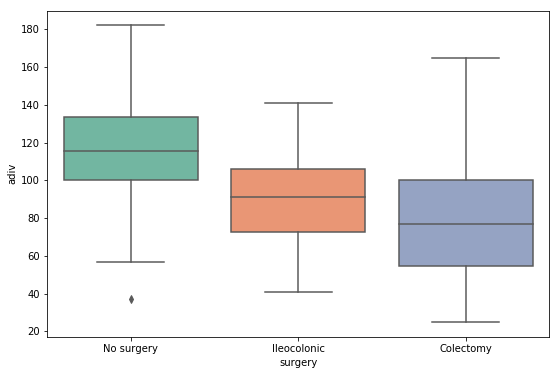

In [51]:
# solids for surgery subtypes

import matplotlib.pyplot as plt
import seaborn as sns

colors = {
     'Ileocolonic': '#fc8d62',
     'Colectomy': '#8da0cb',
     'No surgery': '#66c2a5',
}


fig, ax = plt.subplots(figsize=(9, 6))

sns.boxplot(x='surgery', y='adiv',
             data=df_adiv, ax=ax,
             order=['No surgery', 'Ileocolonic', 'Colectomy'],
             palette=colors)

fig.savefig('../../../data/Sandborn_data/figures/Fig1C_1121.pdf')
fig.savefig('../../../data/Sandborn_data/figures/Fig1C_1121.svg')

In [44]:
## Test the the statistical significance between 3 subgroups 

from scipy.stats import kruskal
print (kruskal(df_alpha_no,df_alpha_ilealcolonic,df_alpha_colectomy))


KruskalResult(statistic=69.19572337240452, pvalue=9.426263679079968e-16)


### Split the subgroups by endoscopic activity

In [39]:
active_surgery=[]
inactive_surgery=[]
active_no=[]
inactive_no=[]

for i in df_spe_taxID: 
    if dic_activity[i]=='active': 
        if dic_surgery[i]=='none': 
            active_no.append(i)
        else: 
            active_surgery.append(i)
    elif dic_activity[i]=='inactive': 
        if dic_surgery[i]=='none': 
            inactive_no.append(i)
        else: 
            inactive_surgery.append(i)

# extract the alpha diversity 

alpha_active_no=adiv_faith.loc[active_no]
alpha_inactive_no=adiv_faith.loc[inactive_no]
alpha_active_surg=adiv_faith.loc[active_surgery]
alpha_inactive_surg=adiv_faith.loc[inactive_surgery]


In [52]:
print (mannwhitneyu(active_surgery,inactive_surgery))
print (mannwhitneyu(active_no,inactive_no))


MannwhitneyuResult(statistic=382.0, pvalue=0.3660525603860326)
MannwhitneyuResult(statistic=1663.0, pvalue=0.474739344962557)


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


(0.5, 4)

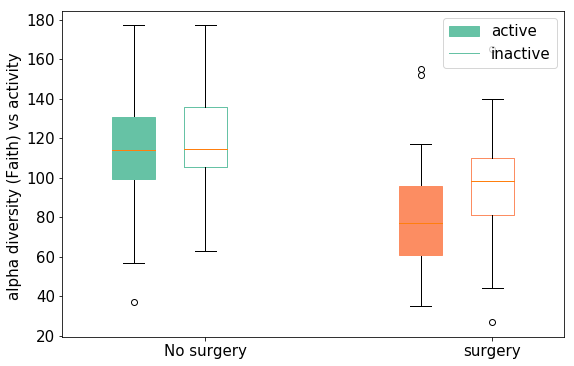

In [43]:
## plot faith alpha diversity for these  different groups 

import matplotlib
from matplotlib import pyplot as plt 

data_to_plot=[alpha_active_no,alpha_active_surg]
data_to_plot2=[alpha_inactive_no,alpha_inactive_surg]

matplotlib.rcParams.update({'font.size': 15})
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp1=ax.boxplot(data_to_plot,positions=[1,3], patch_artist=True) 
bp2=ax.boxplot(data_to_plot2,positions=[1.5,3.5]) 

# fill with colors
colors = ['#66c2a5', '#fc8d62']
for bplot in (bp1, bp2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_color(color)
    
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['active', 'inactive'], loc='upper right')

ax.set_xticklabels(['No surgery', 'surgery'])
ax.set_ylabel('alpha diversity (Faith) vs activity ')
ax.set_xlim(0.5,4)

### Separate by both disease and surgery status

In [47]:
disease=[]
surgery=[]
for i in df_adiv.index: 
    disease.append(dic_subtype[i])
    if dic_surgery[i]=='none': 
        surgery.append('No surgery')
    else: 
        surgery.append('Surgery')
        
df_adiv['Surgery']=surgery
df_adiv['Disease']=disease
df_adiv

,adiv,surgery,Surgery,Disease
PLCL20541,27.0,Colectomy,Surgery,cd
PLCL22214,65.0,Colectomy,Surgery,cd
PLCL21552,156.0,No surgery,No surgery,cd
PLCL18894,103.0,No surgery,No surgery,uc
PLCL18890,109.0,No surgery,No surgery,cd
PLCL18891,119.0,Ileocolonic,Surgery,cd
PLCL21485,106.0,No surgery,No surgery,cd
PLCL18893,177.0,No surgery,No surgery,cd
PLCL20145,122.0,No surgery,No surgery,cd
PLCL20144,115.0,No surgery,No surgery,cd


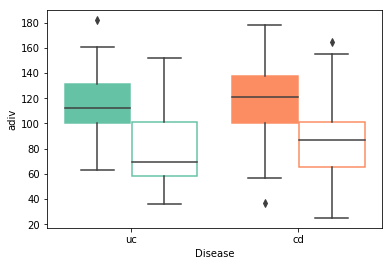

In [52]:

colors = {
     'Surgery': '#fc8d62',
     'No surgery': '#66c2a5',
}

fig, ax = plt.subplots()

sns.boxplot(x='Disease', y='adiv', hue='Surgery', data=df_adiv, order=['uc', 'cd'],
             hue_order=['No surgery', 'Surgery'], ax=ax)

for i, color in enumerate(['#66c2a5', '#66c2a5', '#fc8d62', '#fc8d62']):
    if ((i + 1) % 2) == 0:
        ax.artists[i].set_facecolor('white')
        ax.artists[i].set_edgecolor(color)
    else:
         ax.artists[i].set_color(color)
ax.get_legend().set_visible(False)
fig.savefig('../../../data/Sandborn_data/figures/Fig1A_1121.pdf')
fig.savefig('../../../data/Sandborn_data/figures/Fig1A_1121.svg')


### Separate by more detailed surgery types in UC/CD

In [53]:
# filter out samples that has metagenomics data available
df_meta=df_meta.loc[adiv_faith.index]
print (df_meta.shape)

# Define subgroups in UC 
df_uc=df_meta[df_meta.category1=='uc']
print ('UC: ', len(df_uc))
df_uc_nosurgery=df_uc[df_uc.category2=='Control']
print ('UC_no_surgrey: ', len(df_uc_nosurgery))
df_uc_colec_normal=df_uc[df_uc.category3=='Subsequent normal pouch']
print ('UC_colectomy_pouch: ', len(df_uc_colec_normal))
df_uc_colec_cd=df_uc[df_uc.category3=='Subsequent dev of CD']
print ('UC_colectomy_devCD: ', len(df_uc_colec_cd))
df_uc_colec_pouchitis=df_uc[df_uc.category3=='Pouchitis']
print ('UC_colectomy_pouchitis: ', len(df_uc_colec_pouchitis))


# Define subgroups in CD
df_cd=df_meta[df_meta.category1=='cd']
print ('CD: ', len(df_cd))
df_cd_nosurgery=df_cd[df_cd.category2=='Control']
print ('CD_no_surgrey: ', len(df_cd_nosurgery))
df_cd_end=df_cd[df_cd.category2=='End ileostomy']
print ('CD colectomy with end leostomy: ', len(df_cd_end))
df_cd_ileocolonic=df_cd[df_cd.category2=='Ileocolonic resection']
print ('CD_ileocolonic: ', len(df_cd_ileocolonic))
df_cd_col_ileorectal=df_cd[df_cd.category2=='Ileorectal anastomosis']
print ('CD colectomy with ileorectal anastomosis: ', len(df_cd_col_ileorectal))


## extract the alpha diversity 

alpha_uc_colec_normal=adiv_faith.loc[df_uc_colec_normal.index]
alpha_uc_colec_pouchitis=adiv_faith.loc[df_uc_colec_pouchitis.index]
alpha_uc_no=adiv_faith.loc[df_uc_nosurgery.index]
alpha_uc_CD_pouch=adiv_faith.loc[df_uc_colec_cd.index]

alpha_cd_ileocolonic=adiv_faith.loc[df_cd_ileocolonic.index]
alpha_cd_ileostomy=adiv_faith.loc[df_cd_end.index]
alpha_cd_nosurgery=adiv_faith.loc[df_cd_nosurgery.index]
alpha_cd_ileorectal=adiv_faith.loc[df_cd_col_ileorectal.index]

(300, 86)
UC:  135
UC_no_surgrey:  108
UC_colectomy_pouch:  2
UC_colectomy_devCD:  15
UC_colectomy_pouchitis:  10
CD:  165
CD_no_surgrey:  97
CD colectomy with end leostomy:  10
CD_ileocolonic:  49
CD colectomy with ileorectal anastomosis:  9


KruskalResult(statistic=15.406505779182174, pvalue=0.0004513565792094606)


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


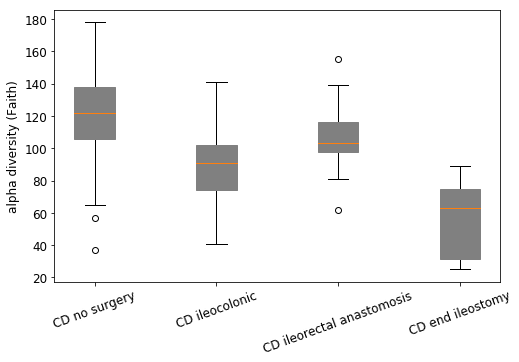

In [56]:
# plot faith alpha diversity for these  different groups 

import matplotlib
from matplotlib import pyplot as plt 

data_to_plot=[alpha_cd_nosurgery,alpha_cd_ileocolonic,alpha_cd_ileorectal,alpha_cd_ileostomy]

matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(1, figsize=(8,5))
ax = fig.add_subplot(111)
bp1=ax.boxplot(data_to_plot,positions=np.linspace(1, 5.5, num=4), patch_artist=True,widths=0.5) 

# fill with colors
for patch in bp1['boxes']:
    patch.set(color='grey')    

ax.set_xticklabels(['CD no surgery',  'CD ileocolonic','CD ileorectal anastomosis','CD end ileostomy'])
ax.set_ylabel('alpha diversity (Faith)')
ax.set_xlim(0.5,6)
plt.xticks(rotation=20)


from scipy.stats import kruskal
print (kruskal(alpha_cd_ileocolonic,alpha_cd_ileostomy,alpha_cd_ileorectal))
plt.savefig('../../../data/Sandborn_data/figures/figureS1A.svg')

KruskalResult(statistic=0.11187493634789046, pvalue=0.9455982640278457)


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


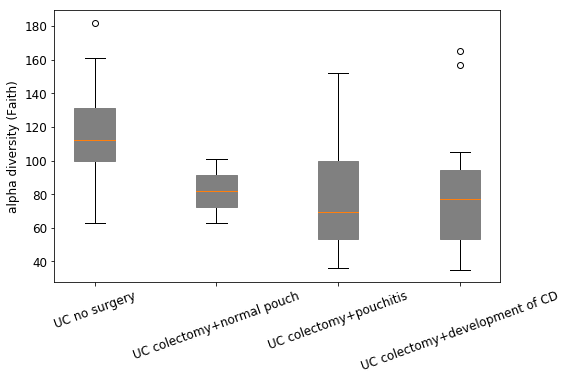

In [57]:
## plot faith alpha diversity for these  different groups 

import matplotlib
from matplotlib import pyplot as plt 

data_to_plot=[alpha_uc_no,alpha_uc_colec_normal,alpha_uc_colec_pouchitis,alpha_uc_CD_pouch]

matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(1, figsize=(8,5))
ax = fig.add_subplot(111)
bp1=ax.boxplot(data_to_plot,positions=np.linspace(1, 5.5, num=4), patch_artist=True,widths=0.5) 

# fill with colors
for patch in bp1['boxes']:
    patch.set(color='grey')   
    
ax.set_xticklabels(['UC no surgery', 'UC colectomy+normal pouch', 'UC colectomy+pouchitis',
                    'UC colectomy+development of CD'])
ax.set_ylabel('alpha diversity (Faith)')
ax.set_xlim(0.5,6)
plt.xticks(rotation=20)

print (kruskal(alpha_uc_colec_pouchitis,alpha_uc_colec_normal,alpha_uc_CD_pouch))
plt.savefig('../../../data/Sandborn_data/figures/figureS1B.svg')

### Statistical test: only include one sample per patient 

In [87]:
## create dictionary for host info 
dic_sample_host=dict(zip(list(df_meta.index),list(df_meta.host_id)))
                   
##empty list to store host info 
cd_ileorectal2=[]
cd_ileocolonic2=[]
cd_ileostomy2=[]
host_ilerectal=[]
host_ileocolonic=[]
host_ileostomy=[]

##only 1 sample per patient 

for s in alpha_cd_ileorectal.index: 
    if not dic_sample_host[s] in host_ilerectal: 
        host_ilerectal.append(dic_sample_host[s])
        cd_ileorectal2.append(s)

for s in alpha_cd_ileocolonic.index: 
    if not dic_sample_host[s] in host_ileocolonic: 
        host_ileocolonic.append(dic_sample_host[s])
        cd_ileocolonic2.append(s)

for s in alpha_cd_ileostomy.index: 
    if not dic_sample_host[s] in host_ileostomy: 
        host_ileostomy.append(dic_sample_host[s])
        cd_ileostomy2.append(s)
alpha_cd_ileorectal2=alpha_cd_ileorectal.loc[cd_ileorectal2]
alpha_cd_ileocolonic2=alpha_cd_ileocolonic.loc[cd_ileocolonic2]
alpha_cd_ileostomy2=alpha_cd_ileostomy.loc[cd_ileostomy2]
print (kruskal(alpha_cd_ileocolonic2,alpha_cd_ileostomy2,alpha_cd_ileorectal2))


KruskalResult(statistic=12.4204087225463, pvalue=0.002008826895697408)


### Association of alpha diversity with surgery time

In [18]:
#extract time passed since surgery and alpha diversity for these samples 

from scipy.stats import spearmanr 
from scipy.stats import pearsonr

sample_surgery=[]
surgeryDate=[]

#calculate time passed since surgery 
for i in range(len(df_meta)): 
    row=df_meta.iloc[i]
    if row.name in df_spe_taxID.columns: 
        if row.year_recent_bowel_surgery!='not provided': 
            time=int(row.collection_timestamp)-int(row.year_recent_bowel_surgery)
            if time > 0: 
                surgeryDate.append(time)
                sample_surgery.append(row.name)
            elif time ==0 and row.weeks_from_surgery!='not applicable': 
                if int(row.weeks_from_surgery)>0: 
                    #print row.name
                    surgeryDate.append(time)
                    sample_surgery.append(row.name)
                
alpha_surgtime=adiv_faith.loc[sample_surgery]


# calculate correlation for time passed since surgery and alpha diversity 
print ('correlation between alpha diversity and surgery date: ')

corrS=spearmanr(surgeryDate,alpha_surgtime)
print (corrS)


correlation between alpha diversity and surgery date: 
SpearmanrResult(correlation=0.049492290494930966, pvalue=0.6394198723359449)


### Calculate correlation of alpha diversity with disease duration, bmi, and age baseline


In [15]:
#extract disease duration and alpha diversity for these samples 

sample_duration=[]
durationList=[]

#calculate time passed since surgery 
for i in range(len(df_meta)): 
    row=df_meta.iloc[i]
    if row.name in df_spe_taxID.columns: 
        if row.disease_duration!=100: 
                durationList.append(row.disease_duration)
                sample_duration.append(row.name)
                
alpha_duration=adiv_faith.loc[sample_duration]

# calculate correlation for time passed since surgery and alpha diversity 
print ('correlation between alpha diversity and disease duration: ')
corrS=spearmanr(durationList,alpha_duration)
print (corrS)

correlation between alpha diversity and disease duration: 
SpearmanrResult(correlation=-0.045920568148002765, pvalue=0.5666909461868834)


In [16]:
#extract bmi and alpha diversity for these samples 

sample_bmi=[]
bmiList=[]

for i in range(len(df_meta)): 
    row=df_meta.iloc[i]
    if row.name in df_spe_taxID.columns: 
        if row.BMI!='missing: not provided': 
                bmiList.append(float(row.BMI))
                sample_bmi.append(row.name)
                
alpha_bmi=adiv_faith.loc[sample_bmi]

# calculate correlation for time passed since surgery and alpha diversity 
print ('correlation between alpha diversity and BMI: ')
corrS=spearmanr(bmiList,alpha_bmi)
print (corrS)


correlation between alpha diversity and BMI: 
SpearmanrResult(correlation=0.1099079711806714, pvalue=0.07518864989211932)


In [17]:
#extract age and alpha diversity for these samples 
#calculate correlation for time passed since surgery and alpha diversity 
print ('correlation between alpha diversity and age at baseline: ')
corrS=spearmanr(df_meta.loc[df_spe_taxID.columns].age_baseline,adiv_faith)
print (corrS)


correlation between alpha diversity and age at baseline: 
SpearmanrResult(correlation=0.027230846632832678, pvalue=0.637955623190798)


### Explore the correlation of alpha diversity and smoking status between UC and CD subtypes

In [18]:
## first look at correlation with smoking status before spliting into subtypes 
sample_smoking=[]
smokeList=[]

for i in range(len(df_meta)): 
    row=df_meta.iloc[i]
    if row.name in df_spe_taxID.columns: 
        if row.smoking_status!=100: 
                smokeList.append(float(row.smoking_status))
                sample_smoking.append(row.name)
alpha_smoke=adiv_faith.loc[sample_smoking]

#correlation test 
never_all=[alpha_smoke.loc[i] for i in sample_smoking if df_meta.loc[i].smoking_status==0]
before_all=[alpha_smoke.loc[i] for i in sample_smoking if df_meta.loc[i].smoking_status==1]
current_all=[alpha_smoke.loc[i] for i in sample_smoking if df_meta.loc[i].smoking_status==2]
from scipy.stats import kruskal
kruskal(never_all,before_all,current_all)


KruskalResult(statistic=0.7515276693505926, pvalue=0.6867645038540338)

In [19]:
# look at disease substypes

cd_sample=[i for i in sample_smoking if df_meta.disease.loc[i]=='cd']
uc_sample=[i for i in sample_smoking if df_meta.disease.loc[i]=='uc']

#correlation test on cd samples 
never_cd=[alpha_smoke.loc[i] for i in cd_sample if df_meta.loc[i].smoking_status==0]
before_cd=[alpha_smoke.loc[i] for i in cd_sample if df_meta.loc[i].smoking_status==1]
current_cd=[alpha_smoke.loc[i] for i in cd_sample if df_meta.loc[i].smoking_status==2]
from scipy.stats import kruskal
kruskal(never_cd,before_cd,current_cd)

#correlation test on uc samples 
never_uc=[alpha_smoke.loc[i] for i in uc_sample if df_meta.loc[i].smoking_status==0]
before_uc=[alpha_smoke.loc[i] for i in uc_sample if df_meta.loc[i].smoking_status==1]
current_uc=[alpha_smoke.loc[i] for i in uc_sample if df_meta.loc[i].smoking_status==2]
from scipy.stats import kruskal
kruskal(never_uc,before_uc,current_uc)

KruskalResult(statistic=5.14416881997107, pvalue=0.07637618011779962)

### Association of alpha diversity with E.coli abundance

In [20]:
#extract ecoli abundance 

ecoli_abund=df_spe_taxID.T[1005520]
corrS=spearmanr(ecoli_abund,adiv_faith)
print (corrS)

SpearmanrResult(correlation=-0.25666423895850665, pvalue=6.4763322990815385e-06)


y=-0.685208x+(113.760405)


Text(0,0.5,'Alpha Diversity (Faith)')

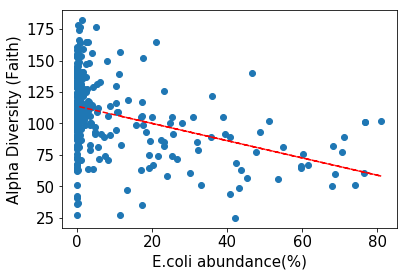

In [21]:
plt.scatter(ecoli_abund,adiv_faith)

# calc the trendline
x=ecoli_abund
z = np.polyfit(ecoli_abund, adiv_faith, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
# the line equation:
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

plt.xlabel('E.coli abundance(%)')
plt.ylabel('Alpha Diversity (Faith)')


## Calculate alpha diversity of pathway abundance generated from humann2

In [225]:
#load pathway abundance

df_pathway=pd.read_csv('./data/Filtered_normalized_cpm_pathways_new_unstratified.csv',index_col=0)
df_pathway=df_pathway.fillna(value=0)
print (df_pathway.shape)

## split the patients into UC, CD and with/without surgery group 
colectomy_pw=[]
ilealcolonic_pw=[]
sugery_none_pw=[]

for i in df_pathway.columns: 
    if i in dic_subtype.keys(): 
        if dic_surgery[i]=='colectomy' or dic_surgery[i]=='partial_colectomy': 
            colectomy_pw.append(i)
        elif dic_surgery[i]=='none': 
            sugery_none_pw.append(i)
        else: 
            ilealcolonic_pw.append(i)

(483, 300)


## Alpha diversity for non-phylogenetic metrics for functional profiles

In [212]:
from skbio.diversity import alpha_diversity

#preprocess data - alpha diversity function only takes in integers

df=df_pathway.transpose()
data_pre=100000*pd.DataFrame.as_matrix(df)
data=data_pre.astype(int)
ids=df.index

#observed OTU
adiv_otus_pw = alpha_diversity('observed_otus', data, ids)
print ('Mean alpha diversity of functional profiles (observed OTU): ' )
print (str(np.mean(list(adiv_otus_pw.data))))

#shannon
adiv_shannon_pw = alpha_diversity('shannon', data, ids)
print ('Mean alpha diversity of functional profiles (shannon): ' )
print (str(np.mean(list(adiv_shannon_pw.data))))


Mean alpha diversity of functional profiles (observed OTU): 
308.46
Mean alpha diversity of functional profiles (shannon): 
7.302150253204357


In [238]:
# extract faith diversity for subgroups separated by surgery subtype
df_alpha_colectomy_pw=adiv_shannon_pw.loc[colectomy_pw]
df_alpha_ilealcolonic_pw=adiv_shannon_pw.loc[ilealcolonic_pw]
df_alpha_no_pw=adiv_shannon_pw.loc[sugery_none_pw]

print ('Mean alpha diversity of no surgery samples(pathway;shannon): ' )
print (str(np.mean(list(df_alpha_no_pw.data))))
print ('Mean alpha diversity of ilealcolonic samples (pathway;shannon): ' )
print (str(np.mean(list(df_alpha_ilealcolonic_pw.data))))
print ('Mean alpha diversity of colectomy samples (pathway;shannon): ' )
print (str(np.mean(list(df_alpha_colectomy_pw.data))))

print (kruskal(df_alpha_colectomy_pw,df_alpha_ilealcolonic_pw,df_alpha_no_pw))


Mean alpha diversity of no surgery samples(pathway;shannon): 
7.21540790968352
Mean alpha diversity of ilealcolonic samples (pathway;shannon): 
7.429147457947354
Mean alpha diversity of colectomy samples (pathway;shannon): 
7.663876178098861
KruskalResult(statistic=38.06828685730808, pvalue=5.414726700147513e-09)


In [230]:
## extract the alpha diversity for pathways 

alpha_uc_colec_normal_pw=adiv_shannon_pw.loc[df_uc_colec_normal.index]
alpha_uc_colec_pouchitis_pw=adiv_shannon_pw.loc[df_uc_colec_pouchitis.index]
alpha_uc_colec_nopouch_pw=adiv_shannon_pw.loc[uc_no_pouch]
alpha_uc_no_pw=adiv_shannon_pw.loc[df_uc_nosurgery.index]
alpha_uc_no_pw=alpha_uc_no_pw.drop('PLCL22244')
alpha_uc_CD_pouch_pw=adiv_shannon_pw.loc[df_cd_pouch.index]

alpha_cd_ileocolonic_pw=adiv_shannon_pw.loc[df_cd_ileocolonic.index]
alpha_cd_ileostomy_pw=adiv_shannon_pw.loc[df_cd_col_ileostomy.index]
alpha_cd_nosurgery_pw=adiv_shannon_pw.loc[df_cd_nosurgery.index]
alpha_cd_colectomy_pw=adiv_shannon_pw.loc[df_cd_col.index]
alpha_cd_ileorectal_pw=adiv_shannon_pw.loc[df_cd_col_ileorectal.index]


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


KruskalResult(statistic=0.5374801230794054, pvalue=0.46347892538464386)


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


(0.5, 4)

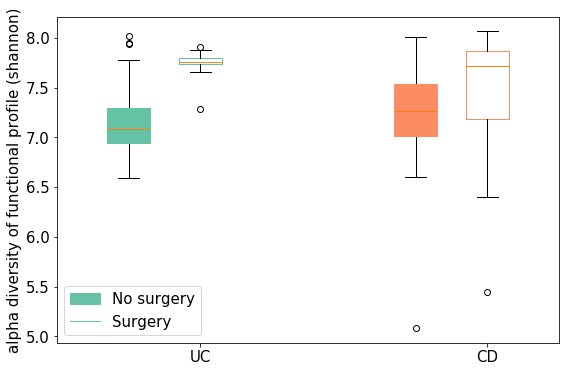

In [234]:
# summarize the data and plot CD and UC separately

alpha_uc_surgery_pw=pd.concat([alpha_uc_colec_normal_pw,alpha_uc_colec_pouchitis_pw,alpha_uc_CD_pouch_pw])
alpha_cd_surgery_pw=pd.concat([alpha_cd_ileocolonic_pw,alpha_cd_ileostomy_pw,
                            alpha_cd_colectomy_pw,alpha_cd_ileorectal_pw])
print (kruskal(alpha_uc_surgery_pw,alpha_cd_surgery_pw))

data_to_plot=[alpha_uc_no_pw,alpha_cd_nosurgery_pw]
data_to_plot2=[alpha_uc_surgery_pw,alpha_cd_surgery_pw]

matplotlib.rcParams.update({'font.size': 15})
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp1=ax.boxplot(data_to_plot,positions=[1,3], patch_artist=True) 
bp2=ax.boxplot(data_to_plot2,positions=[1.5,3.5]) 

# fill with colors
colors = ['#66c2a5', '#fc8d62', '#8da0cb']
for bplot in (bp1, bp2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_color(color)
    
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['No surgery', 'Surgery'], loc='lower left')

ax.set_xticklabels(['UC','CD'])
ax.set_ylabel('alpha diversity of functional profile (shannon)')
ax.set_xlim(0.5,4)


KruskalResult(statistic=5.004852484472025, pvalue=0.08188608194090276)


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


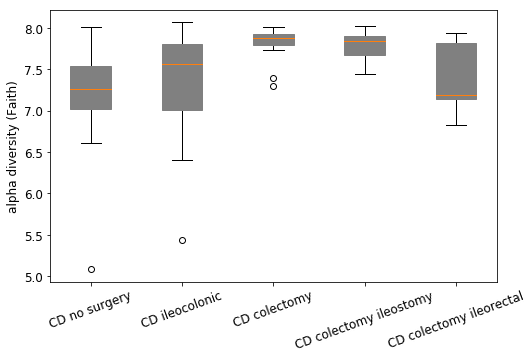

In [232]:
## plot faith alpha diversity for these  different groups 

import matplotlib
from matplotlib import pyplot as plt 

data_to_plot=[alpha_cd_nosurgery_pw,alpha_cd_ileocolonic_pw,alpha_cd_colectomy_pw,alpha_cd_ileostomy_pw,alpha_cd_ileorectal_pw]

matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(1, figsize=(8,5))
ax = fig.add_subplot(111)
bp1=ax.boxplot(data_to_plot,positions=np.linspace(1, 5.5, num=5), patch_artist=True,widths=0.5) 

# fill with colors
for patch in bp1['boxes']:
    patch.set(color='grey')    

ax.set_xticklabels(['CD no surgery', 'CD ileocolonic', 'CD colectomy','CD colectomy ileostomy',
                    'CD colectomy ileorectal'])
ax.set_ylabel('alpha diversity (Faith)')
ax.set_xlim(0.5,6)
plt.xticks(rotation=20)


from scipy.stats import kruskal
print (kruskal(alpha_cd_ileocolonic_pw,alpha_cd_ileostomy_pw,alpha_cd_ileorectal_pw))


KruskalResult(statistic=0.694852941176471, pvalue=0.8744139165683432)


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


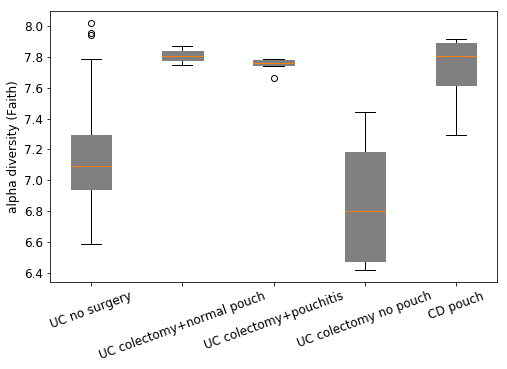

In [233]:
## plot faith alpha diversity for these  different groups 

import matplotlib
from matplotlib import pyplot as plt 

data_to_plot=[alpha_uc_no_pw,alpha_uc_colec_normal_pw,alpha_uc_colec_pouchitis_pw,alpha_uc_colec_nopouch_pw,
              alpha_uc_CD_pouch_pw]

matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(1, figsize=(8,5))
ax = fig.add_subplot(111)
bp1=ax.boxplot(data_to_plot,positions=np.linspace(1, 5.5, num=5), patch_artist=True,widths=0.5) 

# fill with colors
for patch in bp1['boxes']:
    patch.set(color='grey')   
    
#ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['complication', 'no complication'], loc='upper right')

ax.set_xticklabels(['UC no surgery', 'UC colectomy+normal pouch', 'UC colectomy+pouchitis','UC colectomy no pouch',
                    'CD pouch',])
ax.set_ylabel('alpha diversity (Faith)')
ax.set_xlim(0.5,6)
plt.xticks(rotation=20)

print (kruskal(alpha_uc_colec_pouchitis,alpha_uc_colec_normal,alpha_uc_colec_nopouch,alpha_uc_CD_pouch))


In [270]:
df_uc_no=df_pathway[alpha_uc_no_pw.index].quantile(q=[0.25,0.5,0.75,1])
df_uc_s=df_pathway[alpha_uc_surgery_pw.index].quantile(q=[0.25,0.5,0.75,1])
df_cd_no=df_pathway[alpha_cd_nosurgery_pw.index].quantile(q=[0.25,0.5,0.75,1])
df_cd_s=df_pathway[alpha_cd_surgery_pw.index].quantile(q=[0.25,0.5,0.75,1])

df_quantile=pd.DataFrame(index=['25%','50%','75%','100%'])
df_quantile['UC_no_surgery']=list(df_uc_no.mean(axis=1))
df_quantile['CD_no_surgery']=list(df_cd_no.mean(axis=1))
df_quantile['UC_surgery']=list(df_uc_s.mean(axis=1))
df_quantile['CD_surgery']=list(df_cd_s.mean(axis=1))

df_quantile

,UC_no_surgery,CD_no_surgery,UC_surgery,CD_surgery
25%,0.002038,0.010017,0.021186,0.002374
50%,9.180872,16.961941,36.038917,31.864177
75%,74.127024,82.904208,159.454046,124.354626
100%,743.507028,711.912794,649.770167,670.942190
